# Quadreal Challenge
### *Tanvir Deol & Navjot Singh*
### Purpose:

We attempt to devise a solution to predict missing values for data generated by IAQ sensors in the occasion of outages. We are given data for building IDs, device IDs of IAQ sensors, and the values of various chemicals, temperatures and relative humidities collected by the sensors over the timespan of 2023.

Additionally we propose a solution for detecting anomalies for this IAQ sensor data which can be used by sensors to identify and flag abnormal air conditions.

---
### Contents:
```
1.  Data Cleaning + Preprocessing
    1.1 Loading Data
    1.2 Making Data Useable
    1.3 Basic Features

2 Data Analysis
    2.1 Basic Plots
    2.2 Time Based Plots
    2.3 GroupBy Mean Values

3 Feature Engineering
    3.3 K-fold Mean Target Encoding

4 Cross Validation + Model
    4.1 Applying K-fold Mean Target Encoding to Test Set
    4.2 Cross Validation
    4.3 Model

5 Evaluation

6 Creating the Submission

7 Anomaly Detection
    7.1 Isolation Forest
    7.2 Visualizing Results
    
8 Conclusion
    8.1 Reflection
    8.2 Things we Considered
    8.3 Future Improvements
```

---

### List of Concepts Used from Workshops
- Tree Based vs Linear Models
- Ensemble Models: Decision Tree/ Random Forests/ XGBoost
- Overfitting using Regularization
- Numpy/ Matplotlib/ Pandas/ Scikit Learn
- Handling Data Types



## 1 Data Cleaning + Preprocessing
### 1.1 Loading Data
We first import the devices, sample readings and reading types data

In [ ]:
# Import required libaries
import time
import pandas as pd
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Read Data
BASE_PATH = "/content/drive/MyDrive/data"
devices = pd.read_csv(f"{BASE_PATH}/devices.csv")
readings = pd.read_csv(f"{BASE_PATH}/sampled_readings.csv")
reading_types = pd.read_csv(f"{BASE_PATH}/reading_types.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Making Data Usable
To gather all the useful data in one place, we merge the building IDs data with the sample readings. All of the data now is under a DataFrame `df`

Then we handle the NA values. We can see there are 0 NA values in the data. If there were rows with NA values we would drop them.

After that we parse the date column into a useable format, and extract it's individual time components like month, day, day of week, hour, minute, second.

In [ ]:
# MERGE WITH BUILDING ID
devices["device_id"] = devices["device_id"].astype(int)
readings["device_id"] = readings["device_id"].astype(int)
df = pd.merge(readings, devices, how='left',on='device_id')
df = df.head(5000000)


# Handle NA samples
print(df.isna().sum())
df = df.dropna()

# DATE FEATURES
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second

device_id        0
date             0
value_type_id    0
value            0
building_id      0
dtype: int64


### 1.3 Basic Features
We create some basic features from our time data. These will help us shortly in the future to visualize/analyze the data to pick up key insights about the behavior of IAQ sensor readings.

`seconds_from_start_of_day`: Gives us a single cyclical numerical value to measure how far we are into a given day. It can help us visualize daily trends of sensor readings.

`minutes_from_start_of_day`: Is a less fine-grained version of the above feature

`days_from_start_of_year`: Gives us a single cyclical numerical value to measure how far we are into a given year. It can help us visualize yearly trends of sensor readings.

`season`: Gives us ordinal values regarding which one of the 4 seasons a IAQ reading is in. It can help show us changes in IAQ sensor readings depending on the season.

`nine_to_five`: Gives us a binary variable whether the time is within 9AM-5PM or not. It can help us show how IAQ sensor readings changed based on working hour + building occupancy.

In [ ]:
def get_season_numerical(month):
    if 3 <= month <= 5:
        return 1 # Spring
    elif 6 <= month <= 8:
        return 2 # Summer
    elif 9 <= month <= 11:
        return 3 # Fall
    else:
        return 0 # Winter

def check_nine_to_five(hour):
    if hour <= 17 and hour >= 9:
        return 1
    else:
        return 0

df["seconds_from_start_of_day"] = (df['hour']*60*60) + (df["minute"]*60) + (df['second'])
df["minutes_from_start_of_day"] = (df['hour']*60) + (df["minute"])
df["days_from_start_of_year"] = (df['month']*30) + (df["day"])
df["season"] = df["month"].apply(get_season_numerical)
df["nine_to_five"] = df["hour"].apply(check_nine_to_five)
df = df.drop(columns=["date"])

## 2 Data Analysis
### 2.1 Basic Plots
We first plot for each `value_type_id`, `building_id` and `device_id` (X-axis) the possible  ranges for `value` (Y-axis). It helps us see how `value` readings between sets of chemicals, buildings, and devices differ.

#### Insights:
- We notice that `value_type_id` 1 and 3 (CO2 and TVOC) have significantly higher `value` readings than the rest of the `value_type_id's`.

- The range of `value` for `building_id's` and `device_id's` is mostly the same throughout with few exceptions.

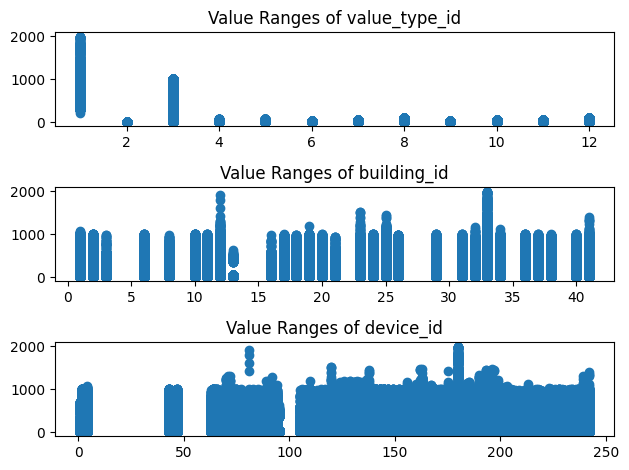

In [ ]:
figure, axis = plt.subplots(3,1)

axis[0].scatter(np.array(df["value_type_id"]),np.array(df["value"]))
axis[0].set_title("Value Ranges of value_type_id")

axis[1].scatter(np.array(df["building_id"]),np.array(df["value"]))
axis[1].set_title("Value Ranges of building_id")

axis[2].scatter(np.array(df["device_id"]),np.array(df["value"]))
axis[2].set_title("Value Ranges of device_id")
figure.tight_layout()
plt.show()

We then plot the Frequency Distribution for each of `device_id`, `building_id` and `value_type_id`.

In other words, this tells us how frequently do we observe each  `device_id`, `building_id` and `value_type_id` in the dataset?

#### Insights:

- We can see that the frequency of different `building_id's` varies a lot. With some being represented way more (1M entries) than others.

- We can see that the frequency of different `devices_id's` is similar for most devices with some outlier exceptions that have a lot.

- The frequency of different `value_type_id's` a lot less varied than the other charts which tells us the chemicals are equally represented in the dataset for the most part.


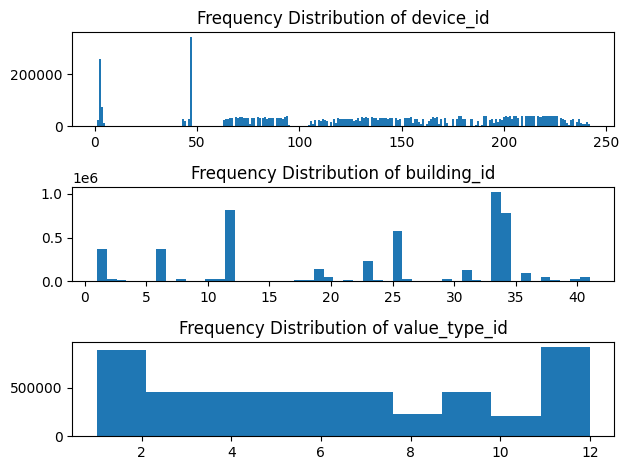

In [ ]:
figure, axis = plt.subplots(3,1)
axis[0].hist(np.array(df["device_id"]),bins=250)
axis[0].set_title("Frequency Distribution of device_id")
axis[1].hist(np.array(df["building_id"]),bins=50)
axis[1].set_title("Frequency Distribution of building_id")
axis[2].hist(np.array(df["value_type_id"]))
axis[2].set_title("Frequency Distribution of value_type_id")
figure.tight_layout()
plt.show()

### 2.2 Time Based Plots
Now that we've looked at basic plots about range and frequency distributions we will look at Time Based plots, which show how certain values change over time.

We have shown 12 scatter plots for each `value_type_id` sensor reading that comes from `building_id` 1, and we plot these over the course of a year.

The top left plot is `value_type_id` 1 and the bottom right is `value_type_id` 12.

#### Insights:

- We can see that for a given building the behavior of IAQ sensor readings over time are *drastically different*.
- `value_type_id` 3 readings take up every possible range overtime, whilst `value_type_id` 4, 5, and 6 start dispersed in the first half of the year and flatline to a constant value for the rest of the year.
- These plots seem to show mostly *non-linear* trends and distributions, which tells us that tree based models would be a good idea rather than linear models.

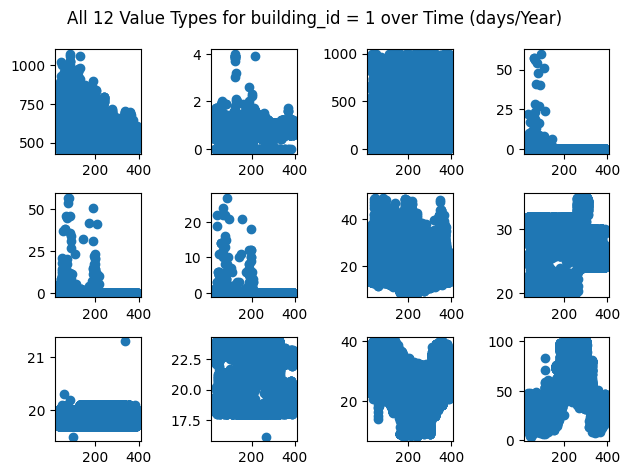

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for building_id = 1 over Time (days/Year)")
selected_id  = 1
building_id  = 1
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["building_id"]== building_id)]
        axis[i,j].scatter(np.array(filter_df["days_from_start_of_year"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

Next we look at the exact same type of plot as before but for `building_id` 3. We chose `building_id` 3 to show in this notebook because its plots look drastically different from `building_id` 1 so its a good example. However there are many other `building_id` that also satisfy this condition.

#### Insights:

- Again we can see that for a given building the behavior of IAQ sensor readings over time are *drastically different*.
- Comparing this plot and the previous one we know that every thing is the same except `building_id's`. This shows us that the IAQ sensor `value` readings for different buildings are also drastically different.
- The `value_type_id` plots for `building_id` 3 tend to be more sparse and flatline looking compared to `building_id` 1. This could tell us that these two buildings are either in entirely different geographies or are completely different internally.
- These plots tell us that it would be a good idea to NOT group `building_id's` together and instead treat them like completely different contexts/environments for air conditions.

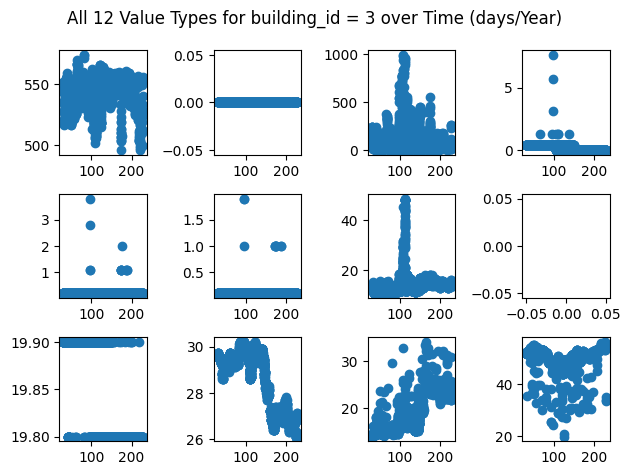

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for building_id = 3 over Time (days/Year)")
selected_id  = 1
building_id  = 3
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["building_id"]== building_id)]
        axis[i,j].scatter(np.array(filter_df["days_from_start_of_year"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

Next we repeat the same plots as before for `building_id` 1, but this time we look at the IAQ sensor `value` readings over the span of a given day rather than a given year.

#### Insights:

- We can see that from a perspective of a given day, the scatter plots look more uniform and symmetrical compared to the (days/Year) plots before.
- The (days/Year) plots seem to show us more detailed macro patterns, while these (minutes/Day) plots seem to capture less clearly defined patterns.

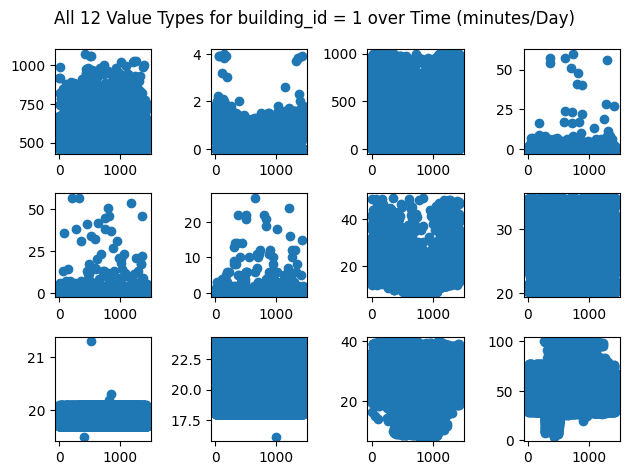

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for building_id = 1 over Time (minutes/Day)")
selected_id  = 1
building_id  = 1
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["building_id"]== building_id)]
        axis[i,j].scatter(np.array(filter_df["minutes_from_start_of_day"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

We repeat the (minutes/Day) plot this time for `building_id` 3.

#### Insights:

- `building_id` 1's seems to have heavily densely populated scatter plots and `building_id` 3 seems to have sparse flat lined scatter plots. These observations still hold from the (days/Year) plots from before.

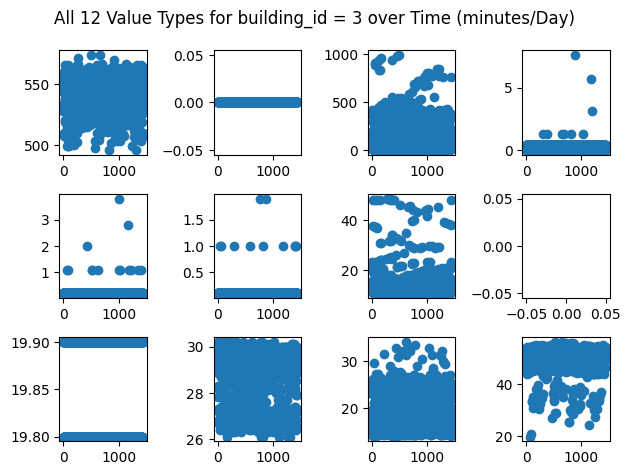

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for building_id = 3 over Time (minutes/Day)")
selected_id  = 1
building_id  = 3
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["building_id"]== building_id)]
        axis[i,j].scatter(np.array(filter_df["minutes_from_start_of_day"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

For the next 3 plots we plot scatter plots of `value_type_id` of the course of a year when:
- `device_id` = 1
- `hour` = 5
- `month` = 3

These values are chosen randomly just for example purposes.

#### Insights :
- Similar to the previous `building_id` plots we can see that the scatter plots for every `device_id`, `hour`, and `month` have drastically different non-linear trends
- So it is likely a good idea to treat every different `building_id`, `device_id`, `hour`, and `month` as independent "sub-contexts" and find out how well `value` correlates with each of these "sub-contexts"
- We could choose to create 3x4 `value_type_id` plots for more features but we choose to stop here because features with too many distinct values won't have enough data for their "subcontexts" and features with too few distinct value are unlikely to tell the model additional insights than what we already have.


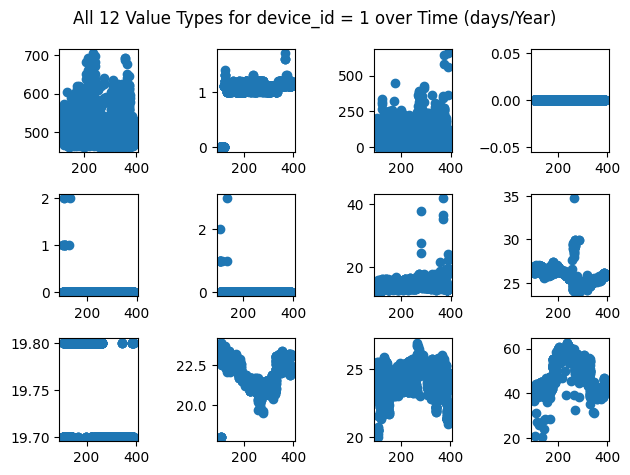

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for device_id = 1 over Time (days/Year)")
selected_id  = 1
device_id  = 1
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["device_id"]== device_id)]
        axis[i,j].scatter(np.array(filter_df["days_from_start_of_year"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

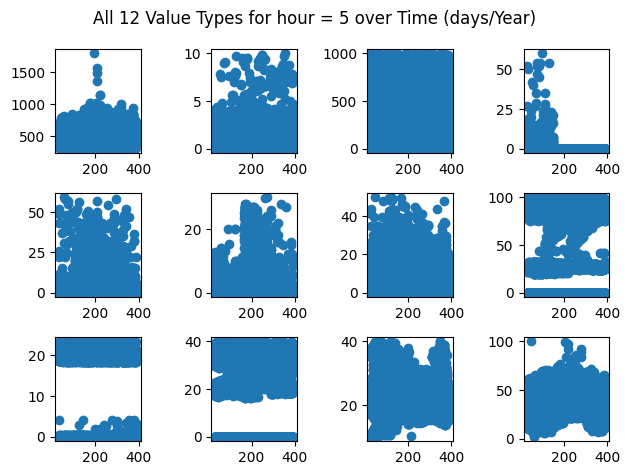

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for hour = 5 over Time (days/Year)")
selected_id  = 1
hour  = 5
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["hour"]== hour)]
        axis[i,j].scatter(np.array(filter_df["days_from_start_of_year"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

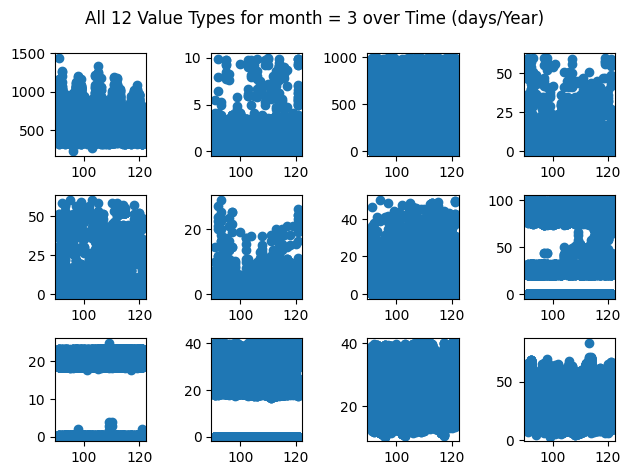

In [ ]:
figure, axis = plt.subplots(3,4)

figure.suptitle("All 12 Value Types for month = 3 over Time (days/Year)")
selected_id  = 1
month  = 3
for i in range(0,3):
    for j in range(0,4):
        filter_df = df[(df["value_type_id"] == selected_id) & (df["month"]== month)]
        axis[i,j].scatter(np.array(filter_df["days_from_start_of_year"]),np.array(filter_df["value"]))
        selected_id += 1
figure.tight_layout()

plt.show()

### 2.3 Groupby Mean Values
From section 2.2 we noticed from our insights that different values of `building_id`, `device_id`, `hour`, and `month` lead to drastically different `value` scatter plots for each `value_type_id`.

Which tells us that it is a good idea to treat these as independent "sub-contexts" and find out how well `value` correlates with each of these "sub-contexts"

For this reason, for every possible pair of:
- `building_id` & `value_type_id`
- `device_id` & `value_type_id`
- `hour` & `value_type_id`
- `month` & `value_type_id`

We find the mean of its corresponding `value` column. This essentially tells us, for a given `building_id` and `value_type_id` what is a reasonable `value` we can expect to see?

Since the IAQ sensor readings for different buildings, devices, hours, and months behave so differently it is helpful to set these expectations for what the `value` will likely be for each of these "sub-contexts". We proceed to plot the means for all of these.

#### Insights:
- We can see that different combination of (`building_id`, `device_id`, `hour`,`month`) paired with `value_type_id` have very different means for the `value` column.
- Using features based on these values will help the model quickly converge to the general neighborhood of the "correct" `value` measurement. Because we already tell the model what `value` it can roughly expect.

However, there is a slight catch to this. If we use the means of the target variable (`value`) as one of our features, it can cause Data Leakage and lead to overfitting. In the proceeding blocks, we will show how we handle this.

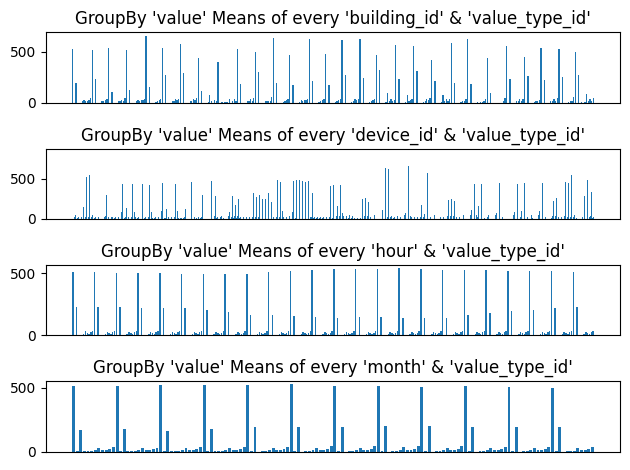

In [ ]:
figure, axis = plt.subplots(4,1)

groupby_mean = df.groupby(["building_id","value_type_id"]).mean()["value"]
x = ['({}:{})'.format(i[0], i[1]) for i in groupby_mean.index]
axis[0].bar(x=x,height=groupby_mean.array)
axis[0].axes.get_xaxis().set_visible(False)
axis[0].set_title("GroupBy 'value' Means of every 'building_id' & 'value_type_id'")

groupby_mean = df.groupby(["device_id","value_type_id"]).mean()["value"]
x = ['({}:{})'.format(i[0], i[1]) for i in groupby_mean.index]
axis[1].bar(x=x,height=groupby_mean.array)
axis[1].axes.get_xaxis().set_visible(False)
axis[1].set_title("GroupBy 'value' Means of every 'device_id' & 'value_type_id'")

groupby_mean = df.groupby(["hour","value_type_id"]).mean()["value"]
x = ['({}:{})'.format(i[0], i[1]) for i in groupby_mean.index]
axis[2].bar(x=x,height=groupby_mean.array)
axis[2].axes.get_xaxis().set_visible(False)
axis[2].set_title("GroupBy 'value' Means of every 'hour' & 'value_type_id'")

groupby_mean = df.groupby(["month","value_type_id"]).mean()["value"]
x = ['({}:{})'.format(i[0], i[1]) for i in groupby_mean.index]
axis[3].bar(x=x,height=groupby_mean.array)
axis[3].axes.get_xaxis().set_visible(False)
axis[3].set_title("GroupBy 'value' Means of every 'month' & 'value_type_id'")

figure.tight_layout()
plt.show()

## 3 Feature Engineering
### 3.1 K-Fold Mean Target Encoding
Now we come to the most critical part of our solution. Here, based on our previous insights we create appropriate features that will help give our model the best information possible to accurately predict missing IAQ sensor values.

The features added here are mainly based on our observations in 2.2 and 2.3. If we were to add the Groupby Mean Values we calculated in 2.3 (see previous plot) as features to our data, this would be called "Mean Target Encoding", which is a known feature engineering technique.

It is called "Mean Target Encoding" because we select particular subsets of the data according to (`building_id`, `device_id`, `hour`,`month` and `value_type_id`) and then calculate the mean of the target column for these subsets. Here the target column is our `value` column.

The problem is that creating features based on your direct target value can lead to Data Leakage and overfitting the model to the training data. So to avoid this we use a variant called "K-Fold Mean Target Encoding".  

---

#### How it Works
- Given your data, split it into k-subsets
- For every row in the $i^{th}$ subset where $i=1...k$ :
    - Use the Mean Target Value that are calculated from *all subsets except the current one*
    - This helps prevent data leakage and overfitting
- Every Mean Target Value calculation has "regularization" applied to it
    - Meaning that for calculations of subsets that don't have lots of availiable data, we use the Mean Target Value of the entire data.

---

Here we apply K-Fold Mean Target Encoding for every possible combination of
- `building_id` & `value_type_id`
- `device_id` & `value_type_id`
- `hour` & `value_type_id`
- `month` & `value_type_id`

In the data. We choose k = 5 because its a good default value.

In [ ]:
!pip install category_encoders
!pip install xgboost==1.3.0.post0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


<img src="./kfold.PNG" width="500"/>

A diagram of K-Fold Mean Target Encoding from a Kaggle Notebook

In [ ]:
import category_encoders as ce
from sklearn.model_selection import KFold

# Split data into 5
kf = KFold(n_splits=5, shuffle=False)

# Creates a new column that is the string concatentation of two columns
# This way for every unique combination of (building, device, hour, month) & (value type)
# We have a unique corresponding row value
def merge_columns(df):
  df["building_vtid"] = df["building_id"].astype(str) + "_" + df["value_type_id"].astype(str)
  df["device_vtid"] = df["device_id"].astype(str) + "_" + df["value_type_id"].astype(str)
  df["hour_vtid"] = df["hour"].astype(str) + "_" + df["value_type_id"].astype(str)
  df["month_vtid"] = df["month"].astype(str) + "_" + df["value_type_id"].astype(str)
  return df

df = merge_columns(df)
df_copy = df.copy()

# Applies K-fold Mean Target Encoding on all 5 subsets of the data
for i, (a_index, b_index) in enumerate(kf.split(df)):
    print(a_index, type(a_index))
    target_encoder = ce.TargetEncoder(cols=["building_vtid","device_vtid","hour_vtid","month_vtid"]).fit(
        df_copy.iloc[a_index],df_copy.iloc[a_index]["value"])
    df.iloc[b_index] = target_encoder.transform(df.iloc[b_index])
    del target_encoder

del df_copy
print(df[["building_vtid","device_vtid","hour_vtid","month_vtid"]])

[1000000 1000001 1000002 ... 4999997 4999998 4999999] <class 'numpy.ndarray'>
[      0       1       2 ... 4999997 4999998 4999999] <class 'numpy.ndarray'>
[      0       1       2 ... 4999997 4999998 4999999] <class 'numpy.ndarray'>
[      0       1       2 ... 4999997 4999998 4999999] <class 'numpy.ndarray'>
[      0       1       2 ... 3999997 3999998 3999999] <class 'numpy.ndarray'>
        building_vtid device_vtid   hour_vtid month_vtid
0            1.291438    2.571192    0.574459   1.260159
1            0.554349    1.464111    1.135829     0.7133
2            0.718455    0.699501    0.578428   0.162735
3           32.279003   36.624436   36.782158  44.885953
4           14.539427   16.796081    8.323491    8.83039
...               ...         ...         ...        ...
4999995      0.151147    0.141477    0.254113   0.325984
4999996     26.745127   26.798227    29.25461  30.940634
4999997     17.271402   19.298231   15.039687  15.392401
4999998      22.71324   21.774995   13.2

## 4 Cross Validation + Model
### 4.1 Applying K-Fold Mean Target Encoding to Test Set
Now that our K-Fold Mean Target Encoding is applied to our train data, we need to know how to import these features into a test data set where we are not given a target column.

Given our train data `X_train` and our test data `X_test` we are already given the Target Encoding features in `X_train` and we need to add them to `X_test`.

We do this by creating 4 groupby tables for `X_train` where for every combination of:
- `building_id` & `value_type_id`
- `device_id` & `value_type_id`
- `hour` & `value_type_id`
- `month` & `value_type_id`

We can instantly access the mean `value` measurement. Then for every row of `X_test` we use these 4 groupby tables to get our corresponding Target Encoding values.

---

### 4.2 Cross Validation
To make sure our MSE results are good and that they consistently hold over the entire data and they do NOT suffer from overfitting. We apply 10-Fold cross validation.

For every one of the 10 iterations we:
- Generate our train data `X_train`, and test data `X_test`
- Apply the Target Encoding features to `X_test`
- Calculate the MSE using our given model

---

### 4.3 Model
For our model we have chosen to go with XGBoost based on our insights made in section 2. We noticed that the scatter plots of `values` had mostly non-linear trends that were best designed for tree-based models to capture. We also have seen from the 3x4 scatter plots that our data has clear patterns in a high-dimensional space.

Given these insights, an obvious answer is Random Forest Models, which essentially aggregate the decisions of hundreds of randomized Decision Trees. However we have chosen to go with XGBoost because it applies Gradient Boosting on Decision Trees.

The difference is that Random Forest generates random independent decision trees in parallel while XGBoost sequentially generates decision trees, where every new tree is trained to minimize the residual error of the current tree ensemble.

In terms of Hyperparamter Tuning we choose to keep it minimal to prevent overfitting. The only parameter we experiment with is the max tree depth parameter for XGBoost. Which essentially puts a upper limit on how complex/deep the decision trees can be.
We experimented with depths `[6,8,10,12,14,16,18,20,22]` and found that 8 and 10 were equally good paramters so we chose 9.

---


Here are diagram that illustrate the difference I am describing.

#### Gradient Boosting (XGBoost)

<img src="./GB.PNG" width="500"/>

### Random Forests

<img src="./RF1.PNG" width="500"/>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def cross_validation(df):
    # Split data into 10 subsets
    kf = KFold(n_splits=10, shuffle=True)
    evals = []

    # train_index is the big one, test_index is the small one
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        X_test = merge_columns(X_test) # We reset the transformed columns

        X_train = X_train.drop(columns=["value"])
        X_test = X_test.drop(columns=["value"])
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)

        y_train = df.iloc[train_index]["value"]
        y_test = df.iloc[test_index]["value"]

        # Groupby Tables
        by_building_chemical = X_train.groupby(["building_id","value_type_id"]).agg({
            'building_vtid': 'mean'
        })
        by_device_chemical = X_train.groupby(["device_id","value_type_id"]).agg({
            'device_vtid': 'mean'
        })
        by_hour_chemical = X_train.groupby(["hour","value_type_id"]).agg({
            'hour_vtid': 'mean'
        })
        by_month_chemical = X_train.groupby(["month","value_type_id"]).agg({
            'month_vtid': 'mean'
        })
        print(i,"Groupby tables made")

        # Apply Target Encoding (of Train Set) on Test Set
        def apply_te_on_test(x, groupby_table, col1, col2, wanted_col):
            try:
                val = groupby_table.loc[(x[col1],x[col2])][wanted_col]
                return val
            except:
                return 0.0

        X_test["building_vtid"] = X_test.apply(lambda x: apply_te_on_test(x, by_building_chemical, "building_id", "value_type_id", "building_vtid"), axis=1)
        X_test["device_vtid"] = X_test.apply(lambda x: apply_te_on_test(x, by_device_chemical, "device_id", "value_type_id", "device_vtid"), axis=1)
        X_test["hour_vtid"] = X_test.apply(lambda x: apply_te_on_test(x, by_hour_chemical, "hour", "value_type_id", "hour_vtid"), axis=1)
        X_test["month_vtid"] = X_test.apply(lambda x: apply_te_on_test(x, by_month_chemical, "month", "value_type_id", "month_vtid"), axis=1)

        # Evaluate MSE using XGBoost Model
        print(i,"Test set made")

        clf = XGBRegressor(tree_method='gpu_hist',random_state=0,max_depth = 9)
        clf.fit(X_train, y_train)
        #print(i, "TRAINING DONE")
        y_val_pred = clf.predict(X_test)
        #print(i, "PREDICTIONS DONE")
        mse = mean_squared_error(y_val_pred, y_test)
        print("MSE:", mse)
        evals.append(mse)

        del X_train, X_test, y_train, y_test
        del by_building_chemical, by_device_chemical
        del by_hour_chemical, by_month_chemical

    return sum(evals) / len(evals)


In [ ]:
!nvidia-smi


## 5 Evaluation
Now onto actually evaluating how well our model does given 10-fold Cross Validation given the Mean Squared Error metric. Nice.

In [ ]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

cross_validation(df)


0 Groupby tables made
0 Test set made
MSE: 2090.4776078915434
1 Groupby tables made
1 Test set made
MSE: 2040.401383801941
2 Groupby tables made
2 Test set made
MSE: 2070.7700533003135
3 Groupby tables made
3 Test set made
MSE: 2097.1479799151
4 Groupby tables made
4 Test set made
MSE: 2049.50105794418
5 Groupby tables made
5 Test set made
MSE: 2091.341910407101
6 Groupby tables made
6 Test set made
MSE: 2136.6883415268644
7 Groupby tables made
7 Test set made
MSE: 2105.1731266752754
8 Groupby tables made
8 Test set made
MSE: 2084.2810675786745
9 Groupby tables made


In [ ]:
!nvidia-smi


## 6 Create Submission
To create our submission.csv, we apply all the transformations, features, and model fitting we applied to the training data to our new `test.csv` test data. Then we save our predictions for the Quadreal Organizers to evaluate.

In [ ]:
df_train = df

import warnings
warnings.filterwarnings('ignore')

BASE_PATH = "data"
devices = pd.read_csv(f"{BASE_PATH}/devices.csv")
readings = pd.read_csv(f"{BASE_PATH}/test.csv") # changed
reading_types = pd.read_csv(f"{BASE_PATH}/reading_types.csv")

readings.columns = ["device_id","date","value_type_id"]
devices["device_id"] = devices["device_id"].astype(int)
readings["device_id"] = readings["device_id"].astype(int)
df = pd.merge(readings, devices, how='left',on='device_id')
df = df.head(1000000)

# Handle NA Samples
print(df.isna().sum())
df = df.dropna()

# DATE FEATURES
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df["seconds_from_start_of_day"] = (df['hour']*60*60) + (df["minute"]*60) + (df['second'])
df["minutes_from_start_of_day"] = (df['hour']*60) + (df["minute"])
df["days_from_start_of_year"] = (df['month']*30) + (df["day"])
df["season"] = df["month"].apply(get_season_numerical)
df["nine_to_five"] = df["hour"].apply(check_nine_to_five)
df = df.drop(columns=["date"])

# Feature Engineering
df = merge_columns(df)

df_train = df_train.astype(np.float32)
df = df.astype(np.float32)
y_train = df_train["value"]
df_train = df_train.drop(columns=["value"])

by_building_chemical = df_train.groupby(["building_id","value_type_id"]).agg({
    'building_vtid': 'mean'
})
by_device_chemical = df_train.groupby(["device_id","value_type_id"]).agg({
    'device_vtid': 'mean'
})
by_hour_chemical = df_train.groupby(["hour","value_type_id"]).agg({
    'hour_vtid': 'mean'
})
by_month_chemical = df_train.groupby(["month","value_type_id"]).agg({
    'month_vtid': 'mean'
})
print("Groupby tables made")

# Apply Target Encoding (of Train Set) on Test Set
def apply_te_on_test(x, groupby_table, col1, col2, wanted_col):
    try:
        val = groupby_table.loc[(x[col1],x[col2])][wanted_col]
        return val
    except:
        return 0.0

df["building_vtid"] = df.apply(lambda x: apply_te_on_test(x, by_building_chemical, "building_id", "value_type_id", "building_vtid"), axis=1)
df["device_vtid"] = df.apply(lambda x: apply_te_on_test(x, by_device_chemical, "device_id", "value_type_id", "device_vtid"), axis=1)
df["hour_vtid"] = df.apply(lambda x: apply_te_on_test(x, by_hour_chemical, "hour", "value_type_id", "hour_vtid"), axis=1)
df["month_vtid"] = df.apply(lambda x: apply_te_on_test(x, by_month_chemical, "month", "value_type_id", "month_vtid"), axis=1)

# Model Fitting
print("Test set made")
clf = XGBRegressor(random_state=0,max_depth = 9)
clf.fit(df_train, y_train)
print( "TRAINING DONE")
y_val_pred = clf.predict(df)
print("PREDICTIONS DONE")
print(y_val_pred)
submission = pd.DataFrame({
    "device_id": readings["device_id"],
    "date": readings["date"],
    "value_type_id": readings["value_type_id"],
    "value": y_val_pred

})
submission.to_csv("submission.csv")



device_id        0
date             0
value_type_id    0
building_id      0
dtype: int64
Groupby tables made
Test set made


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

TRAINING DONE


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

PREDICTIONS DONE
[ 9.4346684e-01  2.2060406e+01 -9.2983216e-02 ...  3.6214611e+01
  4.9716031e+02  4.9716031e+02]


## 7 Anomaly Detection
### 7.1 Isolation Forest

Given that we have solved our primary objective, we move onto the second objective which is proposing a solution for detecting anomalies for IAQ sensor data which can be used by sensors to identify and flag abnormal air conditions.

#### Why we use it

There are a lot of popular methods for Anomaly Detection that can be used such as IQR range, Z scores, Local Outlier Factors. Based on our data and insights, we conclude that the Isolation Forest Model is the best suited model for our scenario. Here is why:
- Based on our insights we have we noticed that the scatter plots had mostly non-linear trends that were best designed for tree-based models to capture.
- We also have seen data has clear patterns that can only be captured in a multivariable high-dimensional space.

Once again, for this reason it makes sense to use tree-based anomaly detection models that are capable of capturing complex high dimensional patterns in the data.

Isolation Forest is a great pick for this because similar to Random Forests and XGBoost it is also based on randomized Decision Trees.

---

#### How it Works at a High Level:

- First the Isolation forest fits the trees to the given dataset
- Now the trees are built based on optimized split thresholds that seperates the data
- Since anomalies are data points that deviate from the norm, the idea is that the anomalies will be placed in the sections of the Decision Tree with the shortest depth
- Because the majority of the normal data will be deeper in the tree so the algorithm can find further differences in it.
- Given a sample data point, the Isolation forest finds how deep it would be placed in the Decision tree. If it is not that deep, it is an anomaly.

In [ ]:
from sklearn.ensemble import IsolationForest
#df = df.drop(columns=["outlier"])
clf = IsolationForest(contamination=0.05).fit(df_train)
outliers = clf.predict(df)
df["outlier"] = outliers
print(df["outlier"].value_counts())


outlier
 1    926755
-1     73245
Name: count, dtype: int64


## 7.2 Visualizing Results
We use T-SNE plots to visualize the outliers against the normal values. We use a smaller sample of the data because using the entire dataset takes too long.

As you can see, the outliers seem to exist in their own non-overlapping dimension spaces compared to the normal values. The normal values seem to form a strong pattern and the outliers seem to exist in the gaps of this pattern.

0.33357369899749756


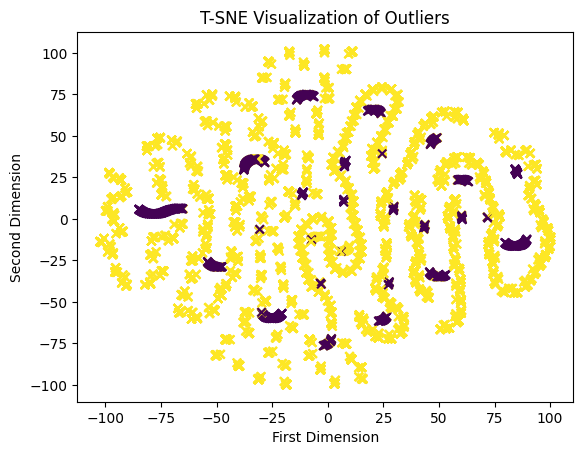

In [ ]:
from sklearn.manifold import TSNE
df["outlier"] = df['outlier'].replace(1,2) # For plot formatting purposes

tsne = TSNE(n_components=2,random_state=0)
df_tsne = tsne.fit_transform(df.head(10000))
print(tsne.kl_divergence_)

plt.scatter(x=df_tsne[:,0],y=df_tsne[:,1],c=df.head(10000)["outlier"],facecolors='none',marker='x')
plt.title("T-SNE Visualization of Outliers")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")
plt.show()


## 8 Conclusion
### 8.1 Reflection
This is our first time doing a Kaggle-Style Data Science Competition. Although we aren't new to data science concepts, it is our first time thinking this deep about a data problem and what possible features we could extract out of a limited data set.

During the course of this competition we encountered lots of unknown territory which led us to learn new things.

#### Doing Data Analysis on Time Series Data:

Going deep into analyzing the time series data taught us about trends, seasonality features, cyclical features, etc. We look at the Kaggle Time Series Course to quickly get caught up on these.

#### K-Fold Mean Target Encoding:

This was the feature that made the biggest different in our MSE score, however we didn't actually know it was a thing prior to this competition. When we were doing data analysis with the 3x4 scatter plots we noticed how there were such strong hidden patterns in the data but we didn't have enough features to know what was actually causing this.

We thought about adding external data, however that wouldn't help much since we didn't know precise geographical locations of the buildings and sensors. Instead we noticed that different subsets of data had completely different correlations with the `value` measure. But we were hesitant on using the means of this because that sounded like overfitting, and felt like it was a bad practice.

However then we learned about the concept of Target Encoding and how data leakage and overfitting can be prevented using K-fold Target Encoding. This was a game changer for us.

#### Isolation Forest:

On a smaller note, although we were familar with popular supervised tree based methods like Random Forests and XGBoost we were not aware of that it had niche unsupervised variant called Isolation forests.

Since they are built on similar underlying architecture we didn't have to repreat a lot of steps for the anomaly detection phase because now with Isolation Forests, we knew it would capture similar underlying patterns compared to XGBoost in our primary objective.

---

### 8.2 Things we Considered
There were a few components we considered adding to our submission, but in the end didn't make the cut.

#### K Means:

When we were looking at the 3x4 scatter plots of `value's` we noticed that although many `building_id's`, and `device_id's` had drastically different plots. Some groups of them had relatively similar plots, which you could technically group into clusters using Kmeans.

The benefit of this would be, if you could compress the ~50 different `building_id's` and ~250 `device_id's` down to a fewer number of clusters then you would have more data to train on per cluster which makes things more accurate.

However this was a time intensive task, and woudldn't yeild significant gains so we left it out.

#### Time Series Hybrid Models:

We were looking at the time series course on Kaggle to learn about trends, seasonality, error features, etc. A common model technique for time series data was to subtract the linear trends, and cylical seasonality trends using some linear model, and then use tree based models to predict the error.

In theory, this would make things more accurate because tree based models like XGBoost are not good at detecting overall trends. However when we tried this, it seemed to reduce the performance, so we left it out.

Perhaps if we took a more rigorious and careful approach to this it would make things better.

#### Feature Selection:

We intended to perform feature selection on the features after the feature engineering stage was finished by calculating the Mutual Information (MI) metric for each feature against the target.

However we noticed we only had 19 features which the models could easily handle so we left this stage out.

---

### 8.3 Future Improvements

In terms of improvments that could be made to this solution given that we have more time. We have:

#### K Means:

As mentioned in detail in 8.2, K means would essentially help compress the `building_id` and `device_id` to a lower dimensional space, giving us more data per cluster, so better performanced.

#### Time Series Hybrid Models:

As mentioned in detail in 8.2, subtract the linear trends, and cylical seasonality trends using some linear model, and then use tree based models to predict the error would in theory make it easier for XGBoost to handle patterns in the data.

We didn't have the time to take a rigorous approach to this, so it is a good future improvement.

#### External Data using Domain Knowledge:

In the future, we could create additional features based on domain knowledge about HVAC schedules of buildings, knowledge about how the chemicals behave in certain air conditions, etc. Our domain knowledge was pretty limited in this aspect which made it hard to confidently generate features based on external data.
